## Importing the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2 
import seaborn as sns
sns.set()

In [6]:
import warnings
warnings.filterwarnings("ignore")

## Importing the Data and Pre-processing 

In [7]:
raw_csv_data = pd.read_csv("Index2023.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = False)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [8]:
df_comp['market_value']=df_comp.ftse

In [9]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## The LLR Test

In [10]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(4)
    return p

## Creating Returns

In [11]:
#Calcula el cambio porcentual entre los valores sucesivos en la columna "market_value"
#mul(100): Multiplica el resultado por 100 para expresar la tasa de rendimiento en términos porcentuales.
df['returns'] = df.market_value.pct_change(1)*100

## ARMA(1,1)

In [13]:
import statsmodels.api as sm
model_ret_ar_1_ma_1 = sm.tsa.SARIMAX(df.returns[1:], order=(1,0,1))
results_ret_ar_1_ma_1 = model_ret_ar_1_ma_1.fit()
results_ret_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6199
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -9498.021
Date:                Mon, 09 Oct 2023   AIC                          19002.042
Time:                        21:54:39   BIC                          19022.238
Sample:                    01-10-1994   HQIC                         19009.044
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8087      0.036     22.761      0.000       0.739       0.878
ma.L1         -0.8505      0.031    -27.021      0.000      -0.912      -0.789
sigma2         1.2542      0.011    110.288      0.000       1.232       1.276
===================================================================================
Ljung-Box (L1) (Q):                   2.22   Jarque-Bera (JB):              9721.14
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
model_ret_ar_1 = sm.tsa.SARIMAX(df.returns[1:], order = (1,0,0))
model_ret_ma_1 = sm.tsa.SARIMAX(df.returns[1:], order = (0,0,1))

In [15]:
print("\nARMA vs AR ", LLR_test(model_ret_ar_1, model_ret_ar_1_ma_1))
print("\nARMA vs MA ", LLR_test(model_ret_ma_1, model_ret_ar_1_ma_1))
#Rechazar la hipótesis nula
#El modelo alternativo (model_ret_ar_1_ma_1) es preferible al modelo nulo (model_ret_ar_1 y model_ret_ma_1) en función de la verosimilitud de los datos observados.


ARMA vs AR  0.0

ARMA vs MA  0.0


## Higher-Lag ARMA Models

In [16]:
model_ret_ar_3_ma_3 = sm.tsa.SARIMAX(df.returns[1:], order=(3,0,3))
results_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()

In [12]:
LLR_test(model_ret_ar_1_ma_1, model_ret_ar_3_ma_3, DF = 4)
#Rechazar la hipótesis nula
#El modelo alternativo (model_ret_ar_3_ma_3) es preferible al modelo nulo (model_ret_ar_1_ma_1) en función de la verosimilitud de los datos observados.

0.0

In [17]:
results_ret_ar_3_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6199
Model:               SARIMAX(3, 0, 3)   Log Likelihood               -9480.688
Date:                Mon, 09 Oct 2023   AIC                          18975.375
Time:                        22:00:08   BIC                          19022.500
Sample:                    01-10-1994   HQIC                         18991.713
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1308      0.071     -1.850      0.064      -0.269       0.008
ar.L2         -0.2101      0.056     -3.745      0.000      -0.320      -0.100
ar.L3          0.4982      0.060      8.283      0.000       0.380       0.616
ma.L1          0.1160      0.067      1.726      0.084      -0.016       0.248
ma.L2          0.1487      0.054      2.734      0.006       0.042       0.255
ma.L3         -0.5747      0.056    -10.253      0.000      -0.685      -0.465
sigma2         1.2471      0.012    104.417      0.000       1.224       1.271
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):              8987.62
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.18
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
model_ret_ar_3_ma_2 = sm.tsa.SARIMAX(df.returns[1:], order=(3,0,2))
results_ret_ar_3_ma_2 = model_ret_ar_3_ma_2.fit()
results_ret_ar_3_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6199
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -9484.511
Date:                Mon, 09 Oct 2023   AIC                          18981.022
Time:                        22:01:03   BIC                          19021.415
Sample:                    01-10-1994   HQIC                         18995.027
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6804      0.067    -10.139      0.000      -0.812      -0.549
ar.L2         -0.3518      0.077     -4.591      0.000      -0.502      -0.202
ar.L3         -0.0960      0.007    -12.946      0.000      -0.111      -0.081
ma.L1          0.6637      0.068      9.761      0.000       0.530       0.797
ma.L2          0.2944      0.077      3.839      0.000       0.144       0.445
sigma2         1.2487      0.012    103.956      0.000       1.225       1.272
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8552.84
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.11
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
model_ret_ar_2_ma_3 = sm.tsa.SARIMAX(df.returns[1:], order=(2,0,3))
results_ret_ar_2_ma_3 = model_ret_ar_2_ma_3.fit()
results_ret_ar_2_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6199
Model:               SARIMAX(2, 0, 3)   Log Likelihood               -9483.392
Date:                Mon, 09 Oct 2023   AIC                          18978.784
Time:                        22:01:29   BIC                          19019.177
Sample:                    01-10-1994   HQIC                         18992.788
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5362      0.070     -7.623      0.000      -0.674      -0.398
ar.L2         -0.0985      0.077     -1.281      0.200      -0.249       0.052
ma.L1          0.5180      0.070      7.391      0.000       0.381       0.655
ma.L2          0.0371      0.076      0.489      0.625      -0.112       0.186
ma.L3         -0.1012      0.007    -13.711      0.000      -0.116      -0.087
sigma2         1.2483      0.012    103.606      0.000       1.225       1.272
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8471.50
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.14
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
LLR_test(model_ret_ar_2_ma_3, model_ret_ar_3_ma_3)
#Rechazar la hipótesis nula
#El modelo alternativo (model_ret_ar_3_ma_3) es preferible al modelo nulo (model_ret_ar_2_ma_3) en función de la verosimilitud de los datos observados.

0.02

In [23]:
model_ret_ar_3_ma_1 = sm.tsa.SARIMAX(df.returns[1:], order=(3,0,1))
results_ret_ar_3_ma_1 = model_ret_ar_3_ma_1.fit()
results_ret_ar_3_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6199
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -9485.665
Date:                Mon, 09 Oct 2023   AIC                          18981.331
Time:                        22:02:46   BIC                          19014.991
Sample:                    01-10-1994   HQIC                         18993.001
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5114      0.067     -7.607      0.000      -0.643      -0.380
ar.L2         -0.0583      0.008     -7.278      0.000      -0.074      -0.043
ar.L3         -0.0931      0.007    -13.151      0.000      -0.107      -0.079
ma.L1          0.4931      0.068      7.220      0.000       0.359       0.627
sigma2         1.2492      0.012    104.816      0.000       1.226       1.273
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8607.51
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.13
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
LLR_test(model_ret_ar_3_ma_1, model_ret_ar_3_ma_2)
#No hay evidencia estadística para rechazar la hipótesis nula
#Ambos modelos (model_ret_ar_3_ma_1 y model_ret_ar_3_ma_2) tienen un rendimiento similar en términos de ajuste a los datos observados 
#y que no hay suficiente evidencia para preferir uno sobre el otro en función de la verosimilitud

0.1287

In [26]:
model_ret_ar_2_ma_2 = sm.tsa.SARIMAX(df.returns[1:], order=(2,0,2))
results_ret_ar_2_ma_2 = model_ret_ar_2_ma_2.fit()
results_ret_ar_2_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6199
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -9497.037
Date:                Mon, 09 Oct 2023   AIC                          19004.074
Time:                        22:04:03   BIC                          19037.735
Sample:                    01-10-1994   HQIC                         19015.744
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0700      0.100     -0.698      0.485      -0.267       0.127
ar.L2          0.7367      0.077      9.527      0.000       0.585       0.888
ma.L1          0.0230      0.102      0.226      0.821      -0.176       0.222
ma.L2         -0.7643      0.083     -9.228      0.000      -0.927      -0.602
sigma2         1.2538      0.012    107.196      0.000       1.231       1.277
===================================================================================
Ljung-Box (L1) (Q):                   3.80   Jarque-Bera (JB):              9491.18
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
model_ret_ar_1_ma_3 = sm.tsa.SARIMAX(df.returns[1:], order=(1,0,3))
results_ret_ar_1_ma_3 = model_ret_ar_1_ma_3.fit()
results_ret_ar_1_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6199
Model:               SARIMAX(1, 0, 3)   Log Likelihood               -9483.493
Date:                Mon, 09 Oct 2023   AIC                          18976.986
Time:                        22:04:23   BIC                          19010.647
Sample:                    01-10-1994   HQIC                         18988.656
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4765      0.064     -7.399      0.000      -0.603      -0.350
ma.L1          0.4584      0.065      7.070      0.000       0.331       0.586
ma.L2         -0.0606      0.008     -7.816      0.000      -0.076      -0.045
ma.L3         -0.1004      0.007    -14.272      0.000      -0.114      -0.087
sigma2         1.2483      0.012    104.689      0.000       1.225       1.272
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8497.84
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
print("\n ARMA(3,2): \tLL = ", results_ret_ar_3_ma_2.llf, "\tAIC = ", results_ret_ar_3_ma_2.aic)
print("\n ARMA(1,3): \tLL = ", results_ret_ar_1_ma_3.llf, "\tAIC = ", results_ret_ar_1_ma_3.aic)


 ARMA(3,2): 	LL =  -9484.511186507865 	AIC =  18981.02237301573

 ARMA(1,3): 	LL =  -9483.493186096195 	AIC =  18976.98637219239


## Residuals for Returns

In [29]:
df['res_ret_ar_3_ma_2'] = results_ret_ar_3_ma_2.resid[1:]

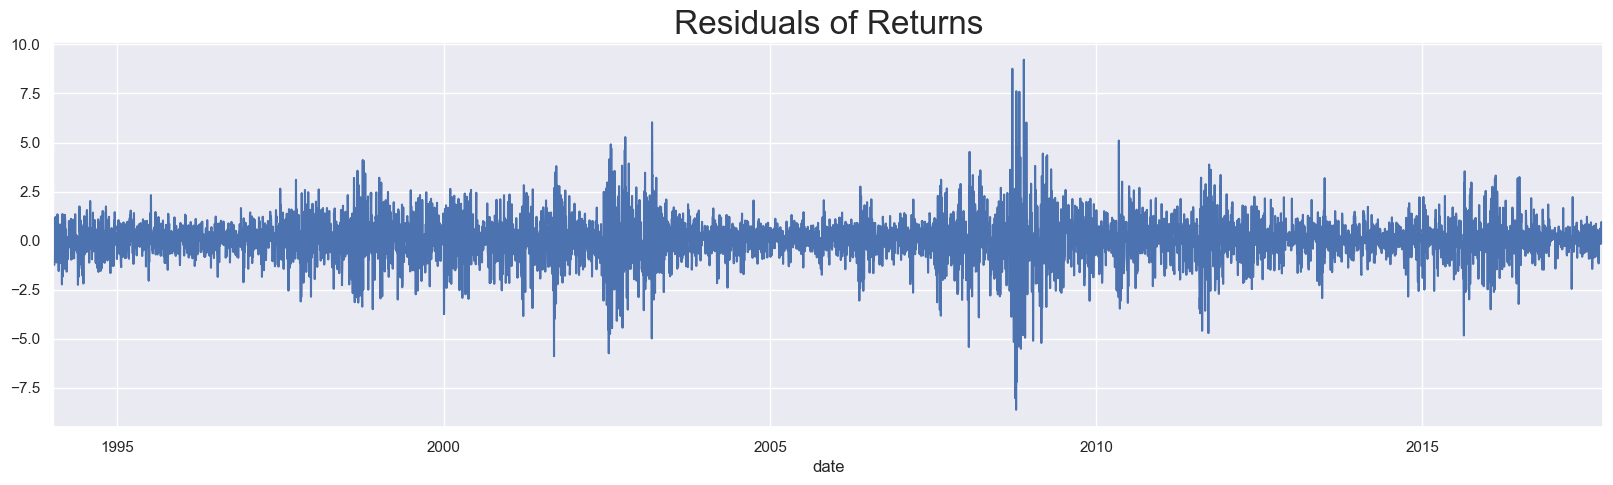

In [30]:
df.res_ret_ar_3_ma_2.plot(figsize = (20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

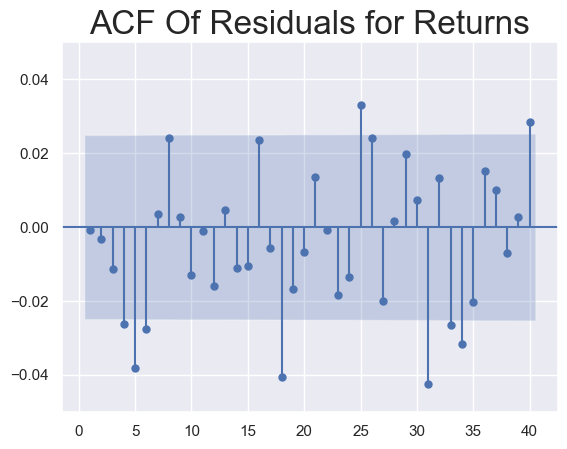

In [33]:
sgt.plot_acf(df.res_ret_ar_3_ma_2[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.ylim(-0.05,0.05)
plt.show()

## Reevaluating Model Selection

In [35]:
model_ret_ar_5_ma_5 = sm.tsa.SARIMAX(df.returns[1:], order=(5,0,5))
results_ret_ar_5_ma_5 = model_ret_ar_5_ma_5.fit()
results_ret_ar_5_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6199
Model:               SARIMAX(5, 0, 5)   Log Likelihood               -9470.153
Date:                Mon, 09 Oct 2023   AIC                          18962.305
Time:                        22:33:39   BIC                          19036.359
Sample:                    01-10-1994   HQIC                         18987.980
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1043      0.120     -0.866      0.387      -0.340       0.132
ar.L2         -0.4145      0.070     -5.952      0.000      -0.551      -0.278
ar.L3         -0.0065      0.063     -0.102      0.919      -0.130       0.117
ar.L4          0.3824      0.066      5.829      0.000       0.254       0.511
ar.L5          0.2630      0.095      2.772      0.006       0.077       0.449
ma.L1          0.0856      0.120      0.716      0.474      -0.149       0.320
ma.L2          0.3689      0.070      5.302      0.000       0.233       0.505
ma.L3         -0.0661      0.062     -1.073      0.283      -0.187       0.055
ma.L4         -0.3711      0.064     -5.834      0.000      -0.496      -0.246
ma.L5         -0.3304      0.091     -3.630      0.000      -0.509      -0.152
sigma2         1.2463      0.012    101.543      0.000       1.222       1.270
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              8505.17
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.21
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
model_ret_ar_5_ma_1 = sm.tsa.SARIMAX(df.returns[1:], order=(5,0,1))
results_ret_ar_5_ma_1 = model_ret_ar_5_ma_1.fit()
results_ret_ar_5_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6199
Model:               SARIMAX(5, 0, 1)   Log Likelihood               -9475.898
Date:                Mon, 09 Oct 2023   AIC                          18965.797
Time:                        22:33:55   BIC                          19012.922
Sample:                    01-10-1994   HQIC                         18982.135
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3150      0.103      3.046      0.002       0.112       0.518
ar.L2         -0.0455      0.008     -5.555      0.000      -0.062      -0.029
ar.L3         -0.0536      0.009     -5.879      0.000      -0.071      -0.036
ar.L4          0.0514      0.010      4.937      0.000       0.031       0.072
ar.L5         -0.0703      0.007     -9.588      0.000      -0.085      -0.056
ma.L1         -0.3338      0.104     -3.206      0.001      -0.538      -0.130
sigma2         1.2453      0.012    104.303      0.000       1.222       1.269
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              8551.40
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.18
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
model_ret_ar_1_ma_5 = sm.tsa.SARIMAX(df.returns[1:], order=(1,0,5))
results_ret_ar_1_ma_5 = model_ret_ar_1_ma_5.fit()
results_ret_ar_1_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6199
Model:               SARIMAX(1, 0, 5)   Log Likelihood               -9476.970
Date:                Mon, 09 Oct 2023   AIC                          18967.941
Time:                        22:34:08   BIC                          19015.066
Sample:                    01-10-1994   HQIC                         18984.279
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2944      0.123      2.391      0.017       0.053       0.536
ma.L1         -0.3141      0.123     -2.544      0.011      -0.556      -0.072
ma.L2         -0.0425      0.008     -5.060      0.000      -0.059      -0.026
ma.L3         -0.0548      0.010     -5.513      0.000      -0.074      -0.035
ma.L4          0.0519      0.012      4.350      0.000       0.029       0.075
ma.L5         -0.0617      0.008     -8.110      0.000      -0.077      -0.047
sigma2         1.2457      0.012    103.803      0.000       1.222       1.269
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8572.25
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.19
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
print("ARMA(5,1):  \t LL = ",results_ret_ar_5_ma_1.llf,"\t AIC = ",results_ret_ar_5_ma_1.aic)
print("ARMA(1,5):  \t LL = ",results_ret_ar_1_ma_5.llf,"\t AIC = ",results_ret_ar_1_ma_5.aic)

ARMA(5,1):  	 LL =  -9475.89847793334 	 AIC =  18965.79695586668
ARMA(1,5):  	 LL =  -9476.970343692743 	 AIC =  18967.940687385486


In [39]:
print("ARMA(3,2):  \t LL = ",results_ret_ar_3_ma_2.llf,"\t AIC = ",results_ret_ar_3_ma_2.aic)

ARMA(3,2):  	 LL =  -9484.511186507865 	 AIC =  18981.02237301573


## Residuals for the New Model

In [40]:
df['res_ret_ar_5_ma_1'] = results_ret_ar_5_ma_1.resid

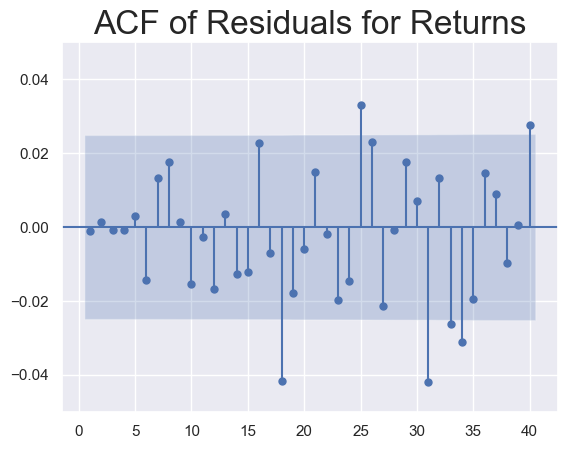

In [43]:
sgt.plot_acf(df.res_ret_ar_5_ma_1[1:], zero = False, lags = 40)
plt.title("ACF of Residuals for Returns",size=24)
plt.ylim(-0.05,0.05)
plt.show()

## ARMA Models for Prices

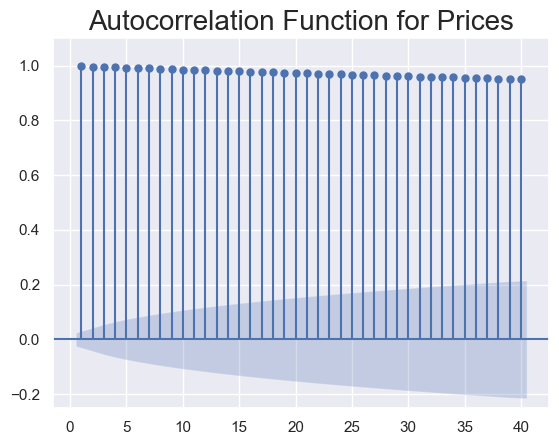

In [45]:
sgt.plot_acf(df.market_value, unbiased=True, zero = False, lags = 40)
plt.title("Autocorrelation Function for Prices",size=20)
plt.ylim(-0.25,1.1)
plt.show()

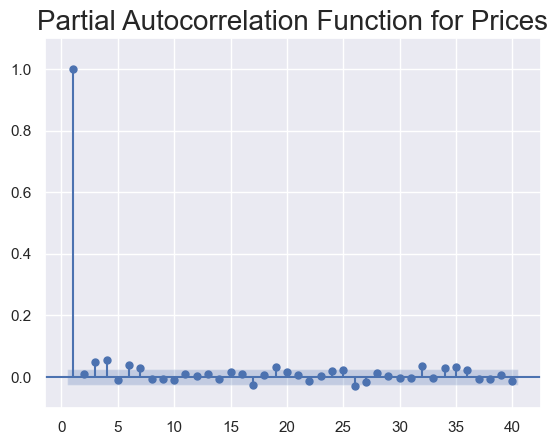

In [47]:
sgt.plot_pacf(df.market_value, lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("Partial Autocorrelation Function for Prices",size=20)
plt.ylim(-0.1,1.1)
plt.show()

In [48]:
model_ar_1_ma_1 = sm.tsa.SARIMAX(df.market_value, order=(1,0,1))
results_ar_1_ma_1 = model_ar_1_ma_1.fit()
results_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 6200
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -34042.616
Date:                Mon, 09 Oct 2023   AIC                          68091.231
Time:                        22:54:27   BIC                          68111.428
Sample:                    01-07-1994   HQIC                         68098.233
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   9401.448      0.000       1.000       1.000
ma.L1         -0.0099      0.009     -1.128      0.259      -0.027       0.007
sigma2      3435.4312     36.779     93.406      0.000    3363.345    3507.518
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3569.11
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -0.20
Prob(H) (two-sided):                  0.12   Kurtosis:                         6.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
df['res_ar_1_ma_1'] = results_ar_1_ma_1.resid

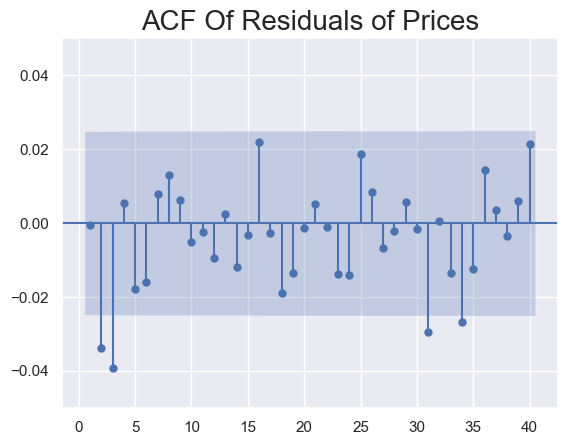

In [52]:
sgt.plot_acf(df.res_ar_1_ma_1, zero = False, lags = 40)
plt.title("ACF Of Residuals of Prices",size=20)
plt.ylim(-0.05,0.05)
plt.show()

In [53]:
model_ar_6_ma_6 = sm.tsa.SARIMAX(df.market_value, order=(6,0,6))
results_ar_6_ma_6 = model_ar_6_ma_6.fit(start_ar_lags = 11)
results_ar_6_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 6200
Model:               SARIMAX(6, 0, 6)   Log Likelihood              -34027.224
Date:                Mon, 09 Oct 2023   AIC                          68080.448
Time:                        22:55:48   BIC                          68167.968
Sample:                    01-07-1994   HQIC                         68110.791
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3022      0.141     -9.219      0.000      -1.579      -1.025
ar.L2         -0.7665      0.091     -8.377      0.000      -0.946      -0.587
ar.L3          0.0470      0.055      0.857      0.391      -0.061       0.155
ar.L4          0.9205      0.057     16.016      0.000       0.808       1.033
ar.L5          1.3071      0.092     14.183      0.000       1.126       1.488
ar.L6          0.7939      0.135      5.884      0.000       0.529       1.058
ma.L1          2.2942      0.141     16.230      0.000       2.017       2.571
ma.L2          3.0316      0.226     13.430      0.000       2.589       3.474
ma.L3          2.9441      0.268     10.981      0.000       2.419       3.470
ma.L4          2.0190      0.221      9.122      0.000       1.585       2.453
ma.L5          0.7349      0.137      5.359      0.000       0.466       1.004
ma.L6         -0.0266      0.009     -2.806      0.005      -0.045      -0.008
sigma2      3423.6792     38.308     89.372      0.000    3348.596    3498.762
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              3380.52
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                            -0.21
Prob(H) (two-sided):                  0.09   Kurtosis:                         6.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
model_ar_5_ma_6 = sm.tsa.SARIMAX(df.market_value, order=(5,0,6))
results_ar_5_ma_6 = model_ar_5_ma_6.fit(start_ar_lags = 7)
results_ar_5_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 6200
Model:               SARIMAX(5, 0, 6)   Log Likelihood              -34023.540
Date:                Mon, 09 Oct 2023   AIC                          68071.079
Time:                        22:56:15   BIC                          68151.867
Sample:                    01-07-1994   HQIC                         68099.088
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3900      0.153     -9.092      0.000      -1.690      -1.090
ar.L2         -0.5926      0.110     -5.365      0.000      -0.809      -0.376
ar.L3          0.9886      0.043     23.210      0.000       0.905       1.072
ar.L4          1.3441      0.146      9.184      0.000       1.057       1.631
ar.L5          0.6494      0.101      6.447      0.000       0.452       0.847
ma.L1          2.3793      0.152     15.619      0.000       2.081       2.678
ma.L2          2.9065      0.244     11.924      0.000       2.429       3.384
ma.L3          1.7992      0.226      7.951      0.000       1.356       2.243
ma.L4          0.4095      0.096      4.268      0.000       0.221       0.598
ma.L5         -0.1660      0.029     -5.754      0.000      -0.223      -0.109
ma.L6         -0.0524      0.013     -3.961      0.000      -0.078      -0.026
sigma2      3417.9434     38.114     89.676      0.000    3343.241    3492.646
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3315.18
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.25
Prob(H) (two-sided):                  0.06   Kurtosis:                         6.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
model_ar_6_ma_1 = sm.tsa.SARIMAX(df.market_value, order=(6,0,1))
results_ar_6_ma_1 = model_ar_6_ma_1.fit(start_ar_lags = 7)
results_ar_6_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 6200
Model:               SARIMAX(6, 0, 1)   Log Likelihood              -34026.191
Date:                Mon, 09 Oct 2023   AIC                          68068.382
Time:                        22:56:39   BIC                          68122.241
Sample:                    01-07-1994   HQIC                         68087.055
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0035      0.186      0.019      0.985      -0.360       0.367
ar.L2          0.9373      0.183      5.110      0.000       0.578       1.297
ar.L3         -0.0422      0.013     -3.166      0.002      -0.068      -0.016
ar.L4          0.0560      0.012      4.734      0.000       0.033       0.079
ar.L5          0.0532      0.015      3.446      0.001       0.023       0.083
ar.L6         -0.0078      0.009     -0.874      0.382      -0.025       0.010
ma.L1          0.9848      0.185      5.318      0.000       0.622       1.348
sigma2      3419.2084     37.865     90.300      0.000    3344.994    3493.423
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3360.20
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                            -0.27
Prob(H) (two-sided):                  0.07   Kurtosis:                         6.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
print("ARMA(5,6):  \t LL = ", results_ar_5_ma_6.llf, "\t AIC = ", results_ar_5_ma_6.aic)
print("ARMA(6,1):  \t LL = ", results_ar_6_ma_1.llf, "\t AIC = ", results_ar_6_ma_1.aic)

ARMA(5,6):  	 LL =  -34023.53974281612 	 AIC =  68071.07948563225
ARMA(6,1):  	 LL =  -34026.19110712128 	 AIC =  68068.38221424256


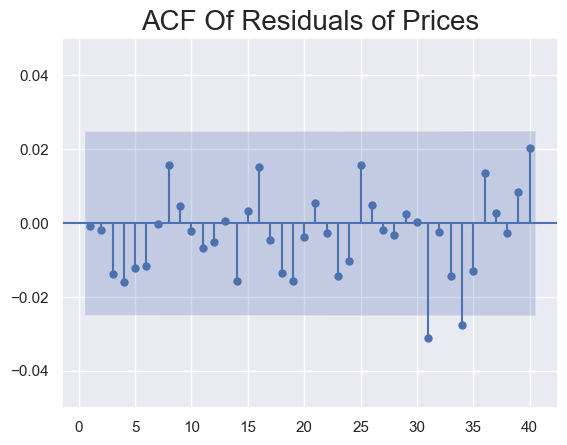

In [58]:
df['res_ar_5_ma_6'] = results_ar_5_ma_6.resid
sgt.plot_acf(df.res_ar_5_ma_6, zero = False, lags = 40)
plt.title("ACF Of Residuals of Prices",size=20)
plt.ylim(-0.05,0.05)
plt.show()

## ARMA for Returns vs ARMA for Prices

In [59]:
print("ARMA(5,6):  \t LL = ", results_ar_5_ma_6.llf, "\t AIC = ", results_ar_5_ma_6.aic)
print("ARMA(5,1):  \t LL = ", results_ret_ar_5_ma_1.llf, "\t AIC = ", results_ret_ar_5_ma_1.aic)

ARMA(5,6):  	 LL =  -34023.53974281612 	 AIC =  68071.07948563225
ARMA(5,1):  	 LL =  -9475.89847793334 	 AIC =  18965.79695586668
